# Fake News Classification 
by Ben Inoyatov
### EDA and Cleaning
---
#### This notebook will load in, clean, wrangle, and apply NLP techniques to two datasets that will be used in the modelling process 
- First, two datasets will be merged together and stripped of any unncessary columns to create a ```main``` data set. 
- ```title``` and ```text``` will be merged together in the ```text``` column
- In addition to tokenizing and downcasing, sentiment analysis will also be explored 
- Stemming and Lemming will be two different datasets so that performance can be tracked among different techniques
- Topic modelling will also be explored to understand the business case better i.e., what actually is 'Fake News'.

In [1]:
# importing standard libraries 
import pandas as pd
from tqdm import tqdm # progress tracker
tqdm.pandas()

/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# two seperate pre-made datasets to concatinate after cleaning for NLP and modeling
first = pd.read_csv('news.csv')
second = pd.read_csv('train.csv')

In [3]:
first.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


- At first glance:
  - change the label to 1s and 0s 
  - join the title and text 

In [4]:
second.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


- label of 1 is unreliabe/fake
- author is not needed but like with the first df, title and text will be merged
---

In [5]:
print(first.shape)
print(second.shape)

(6335, 4)
(20800, 5)


#### Total observations should be 27135

In [6]:
first['text'] = first['title'] + ' ' + first['text']      # joining title and text 
second['text'] = second['title'] + ' ' + second['text']   
first = first[['text', 'label']]                          # only using text and label
second = second[['text', 'label']]
first['label'] = first['label'].apply(lambda x: 1 if x == 'FAKE' else 0) # changing categorical variables to numeric

In [7]:
# concatinating first and second dfs with text and label. 
frames = [first, second] 
main = pd.concat(frames, ignore_index=True)

In [8]:
main

,text,label
0,You Can Smell Hillary’s Fear Daniel Greenfield...,1
1,Watch The Exact Moment Paul Ryan Committed Pol...,1
2,Kerry to go to Paris in gesture of sympathy U....,0
3,Bernie supporters on Twitter erupt in anger ag...,1
4,The Battle of New York: Why This Primary Matte...,0
...,...,...
27130,Rapper T.I.: Trump a ’Poster Child For White S...,0
27131,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",0
27132,Macy’s Is Said to Receive Takeover Approach by...,0
27133,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [9]:
main.isna().sum()

text     597
label      0
dtype: int64

#### Only 2% of data has null values and so dropping them seems best 

In [10]:
main.dropna(inplace=True)

In [11]:
main.reset_index(inplace=True, drop=True)

In [12]:
main.isna().sum()

text     0
label    0
dtype: int64

#### Class balance

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


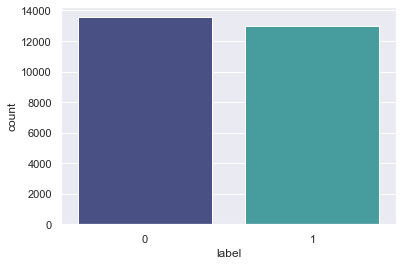

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

sns.countplot(main.label, palette='mako')
plt.savefig('class_balance.png')

- Classes seem very balanced. Using a balanced class_weight in the modelling process should not change results too drastically. 
---


## Tokenized with stop words removed, no lemma or stemming yet 

In [13]:
import nltk

In [14]:
# Importing stop words and punctuations to remove from text 
import string
from nltk.corpus import stopwords

stopwords = stopwords.words(['english', 'russian'])
stopwords += list(string.punctuation)
stopwords += ['’', '“', '”', '–', "'s", "''",
              '—', '``', '‘', '``', 'de', 'la',
             '1', 'mr.', 'ms.', '1', 'mrs.', 'a.',
             'u.', '000', 's.', 'в', "n't", '2', '.', 'в']

In [15]:
# A function to downcase, tokenize, and remove stopwords
def process_article(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return ' '.join(stopwords_removed)

In [18]:
# Using tqdm to track progress
from tqdm import tqdm
tqdm.pandas()
working_text = main.copy()

working_text['text'] = main['text'].progress_apply(process_article)

/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 26538/26538 [23:46<00:00, 18.60it/s]  


In [19]:
working_text

# note 4th column: supporters (no lemming or stemming just stopword removal)

,text,label
0,smell hillary fear daniel greenfield shillman ...,1
1,watch exact moment paul ryan committed politic...,1
2,kerry go paris gesture sympathy u.s. secretary...,0
3,bernie supporters twitter erupt anger dnc 'we ...,1
4,battle new york primary matters primary day ne...,0
...,...,...
26533,rapper t.i trump poster child white supremacy ...,0
26534,n.f.l playoffs schedule matchups odds new york...,0
26535,macy said receive takeover approach hudson bay...,0
26536,nato russia hold parallel exercises balkans na...,1


### Sentiment Analysis 
- Subjectivity: measured from 0 to 1 where 1 is a subjective statement, i.e. a statement based on personal opionion rather than fact
- Polarity: measured from -1 to 1 where -1 is a negative statement and 1 is a positive statement. 0 is neutral

In [21]:
from textblob import TextBlob

In [22]:
def subj(series):
    blob = TextBlob(series)
    return blob.subjectivity
def pola(series):
    blob=TextBlob(series)
    return blob.polarity



In [24]:
working_text['polarity'] = main['text'].progress_apply(pola)

100%|██████████| 26538/26538 [08:30<00:00, 52.01it/s] 


In [26]:
working_text['subjectivity'] = main['text'].progress_apply(subj)

100%|██████████| 26538/26538 [09:27<00:00, 46.78it/s] 


In [27]:
working_text.head()

,text,label,polarity,subjectivity
0,smell hillary fear daniel greenfield shillman ...,1,0.059595,0.562654
1,watch exact moment paul ryan committed politic...,1,0.085219,0.497811
2,kerry go paris gesture sympathy u.s. secretary...,0,0.102574,0.348775
3,bernie supporters twitter erupt anger dnc 'we ...,1,0.027543,0.491887
4,battle new york primary matters primary day ne...,0,0.252738,0.423682


In [28]:
working_text.to_csv('working_text.csv')

### Lemma 

In [16]:
from nltk.stem import WordNetLemmatizer 


In [17]:
lemmatizer = WordNetLemmatizer()

In [18]:
def lemmafunc(article): 
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in stopwords_removed])
    return lemmatized_output

In [19]:
lemmaText = main['text'].progress_apply(lemmafunc)

100%|██████████| 26538/26538 [06:42<00:00, 65.90it/s]


In [20]:
lemmaText

# note 4th column: supporter (no 's' due to lemma)

0        smell hillary fear daniel greenfield shillman ...
1        watch exact moment paul ryan committed politic...
2        kerry go paris gesture sympathy u.s. secretary...
3        bernie supporter twitter erupt anger dnc 'we t...
4        battle new york primary matter primary day new...
                               ...                        
26533    rapper t.i trump poster child white supremacy ...
26534    n.f.l playoff schedule matchup odds new york t...
26535    macy said receive takeover approach hudson bay...
26536    nato russia hold parallel exercise balkan nato...
26537    keep f-35 alive david swanson author activist ...
Name: text, Length: 26538, dtype: object

In [ ]:
lemmaText.to_csv('lemma_text.csv')

### Stemming

In [21]:
from nltk.stem import PorterStemmer
portstem = PorterStemmer()

In [22]:
def stemmer(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    stem = ' '.join([portstem.stem(w) for w in stopwords_removed])
    return stem

In [23]:
stemText = main['text'].progress_apply(stemmer)

100%|██████████| 26538/26538 [11:12<00:00, 39.46it/s]


In [24]:
stemText

# note 4th column: support (due to stem)
# no lemma/stemm: supporters 
# lemma: supporter
# stem: support

0        smell hillari fear daniel greenfield shillman ...
1        watch exact moment paul ryan commit polit suic...
2        kerri go pari gestur sympathi u.s. secretari s...
3        berni support twitter erupt anger dnc 'we tri ...
4        battl new york primari matter primari day new ...
                               ...                        
26533    rapper t.i trump poster child white supremaci ...
26534    n.f.l playoff schedul matchup odd new york tim...
26535    maci said receiv takeov approach hudson bay ne...
26536    nato russia hold parallel exercis balkan nato ...
26537    keep f-35 aliv david swanson author activist j...
Name: text, Length: 26538, dtype: object

In [ ]:
stemText.to_csv('stem_text.csv')

### Topic Modelling using LDA

In [6]:
import gensim
import nltk

In [3]:
working_text = pd.read_csv('working_text.csv')

In [4]:
lda_fake_clean = working_text[working_text['label'] == 1]['text']
lda_true_clean = working_text[working_text['label'] == 0]['text']

In [7]:
lda_fake_token = lda_fake_clean.progress_apply(lambda row: nltk.word_tokenize(row))

100%|██████████| 12980/12980 [01:05<00:00, 199.53it/s]


In [8]:
lda_fake_token

0        [smell, hillary, fear, daniel, greenfield, shi...
1        [watch, exact, moment, paul, ryan, committed, ...
3        [bernie, supporters, twitter, erupt, anger, dn...
5        [tehran, usa, immigrant, grandparents, 50, yea...
6        [girl, horrified, watches, boyfriend, left, fa...
                               ...                        
26526    [maine, gov, lepage, threatens, investigate, c...
26529    [lawyer, kept, hillary, campaign, chief, jail,...
26531    [idiot, destroyed, trump, hollywood, star, get...
26536    [nato, russia, hold, parallel, exercises, balk...
26537    [keeps, f-35, alive, david, swanson, author, a...
Name: text, Length: 12980, dtype: object

In [12]:
dictionary = gensim.corpora.Dictionary(lda_fake_token)
bow_corpus = [dictionary.doc2bow(doc) for doc in lda_fake_token]

lda_fake = gensim.models.LdaMulticore(bow_corpus, 
                                      num_topics=10,
                                      id2word = dictionary,
                                      passes = 7)
lda_fake.show_topics(formatted=False)

[(0,
  [('one', 0.004461786),
   ('.', 0.004437621),
   ('also', 0.0040894966),
   ('new', 0.0037116923),
   ('said', 0.0034502586),
   ('people', 0.0030158889),
   ('health', 0.002875362),
   ('would', 0.002788544),
   ('many', 0.0026202488),
   ('time', 0.0024132866)]),
 (1,
  [('это', 0.011677904),
   ('trump', 0.010274109),
   ('»', 0.004375772),
   ('«', 0.004023876),
   ('очень', 0.0037216782),
   ('вопрос', 0.0028741318),
   ('donald', 0.0028114289),
   ('gold', 0.0025727293),
   ('которые', 0.0022938908),
   ('россии', 0.0020553775)]),
 (2,
  [('die', 0.0066292896),
   ('der', 0.0063157766),
   ('und', 0.0041717384),
   ('people', 0.0039224406),
   ('van', 0.003023999),
   ('war', 0.0028615326),
   ('human', 0.002662771),
   ('government', 0.0026511196),
   ('world', 0.002494202),
   ('u.s.', 0.0023309833)]),
 (3,
  [('trump', 0.012927878),
   ('people', 0.006110112),
   ('clinton', 0.006095841),
   ('.', 0.005214309),
   ('hillary', 0.004993709),
   ('one', 0.0048428103),
   (

- Now to try and find topics for real news

In [10]:
lda_true_token = lda_true_clean.progress_apply(lambda row: nltk.word_tokenize(row))

100%|██████████| 13558/13558 [01:01<00:00, 220.81it/s]


In [13]:
dictionary = gensim.corpora.Dictionary(lda_true_token)
bow_corpus = [dictionary.doc2bow(doc) for doc in lda_true_token]

lda_true = gensim.models.LdaMulticore(bow_corpus, 
                                      num_topics=10,
                                      id2word = dictionary,
                                      passes = 7)
lda_true.show_topics(formatted=False)

[(0,
  [('said', 0.016737226),
   ('police', 0.006397296),
   ('one', 0.00526495),
   ('new', 0.004951339),
   ('people', 0.003979316),
   ('would', 0.0033724708),
   ('city', 0.0032540068),
   ('two', 0.0029972552),
   ('york', 0.002976938),
   ('also', 0.0029074815)]),
 (1,
  [('said', 0.010816821),
   ('new', 0.0068149627),
   ('one', 0.0050268727),
   ('york', 0.0040231072),
   ('would', 0.003989848),
   ('game', 0.0039458512),
   ('time', 0.003555129),
   ('•', 0.0034620229),
   ('first', 0.0033641285),
   ('times', 0.0032864655)]),
 (2,
  [('said', 0.0088145835),
   ('new', 0.005876484),
   ('one', 0.005861683),
   ('like', 0.005461542),
   ('time', 0.0033498006),
   ('york', 0.0033002046),
   ('first', 0.0032954891),
   ('people', 0.0030657027),
   ('show', 0.0030133077),
   ('also', 0.002859017)]),
 (3,
  [('trump', 0.018607203),
   ('said', 0.01037896),
   ('republican', 0.0076241186),
   ('cruz', 0.0053089284),
   ('would', 0.005240214),
   ('state', 0.005095975),
   ('campai